In [1]:
import sys
import os
sys.path.append('/Users/catrionamurray/PycharmProjects/flare_methods/statistics')
sys.path.append('/Users/catrionamurray/PycharmProjects/flare_methods/detection')
sys.path.append('/Users/catrionamurray/PycharmProjects/flare_methods/modeling')
sys.path.append('/Users/catrionamurray/PycharmProjects/flare_methods/plotting')

from flare_class import FlareLightCurve, check_flares_bw

In [2]:
import pandas as pd
from astropy.io import ascii
from imports import *
from utils import *

In [3]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
from xoflares import *
import pymc3_ext as pmx
from pymc3_ext import eval_in_model
import corner
from scipy.stats import norm

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
def plot_flare_fit(flc, params, degree, npeaks, svname=None):
    
    fig, ax = plt.subplots(nrows=3, figsize=(12,8), gridspec_kw={'height_ratios': [3, 1, 1]})
    for xname in ["FWHM", "dX", 'dY', "bkg", "am"]:
        ax[0].plot(flc.t, params[f'{xname}_poly_lc'], label=f'{degree} degree Polynomial ({xname})' )

    if flares_found:
        high_res_t = np.linspace(min(flc.t), max(flc.t), 10000)
        high_res_flare_lc = multiflaremodelnp(high_res_t, params['tpeak'], params['fwhm'], params['ampl']) + params['mean']
        ax[0].plot(high_res_t, high_res_flare_lc, label='Flares')

    residuals = flc.f - params['total_lc']
    chi_sq = np.nansum((residuals / flc.e) ** 2)

    if flares_found:
        fit_params = (degree * 5) + 1 + (3*npeaks)
    else:
        fit_params = (degree * 5) + 1
    degrees_of_freedom = len(flc.t) - fit_params
    reduced_chi_sq = chi_sq / degrees_of_freedom

    # ax[0].plot(flc.t, map_soln['flare_lc'], label='Flares')
    ax[0].plot(flc.t, params['total_lc'], label=f'Total Light Curve Model (chi-sq={round(chi_sq,2)}, reduced chi-sq={round(reduced_chi_sq,2)})')
    ax[0].errorbar(flc.t, flc.f, flc.e, fmt='.', c='k')
    # ax[0].plot(flc.t[flare_i_peak], flc.f[flare_i_peak], 'ro')
    ax[0].legend()
    ax[0].set_ylabel('Relative Flux')
    ax[0].set_xlabel("Time [d]")
    # ax[0].set_ylim(0.99, 1.025)

    ax[1].plot(flc.t, residuals,'k', marker='.')
    ax[1].set_ylabel('Residuals')
    # ax[1].set_ylim(-0.01, 0.01)
    ax[1].set_xlabel("Time [d]")


    # expected std corresponds to the middle of our true uncertainty
    std = np.median(flc.e)
    mu=0.0

    # setting min/max values for scale of normal distribution
    nsigma = 4
    xmin = np.minimum(np.min(residuals), mu - nsigma * std)
    xmax = np.maximum(np.max(residuals), mu + nsigma * std)

    x = np.linspace(xmin, xmax, 500)
    p = norm.pdf(x, mu, std)
    ax[2].hist(residuals, histtype='step', density=True, color='k', label='Histogram of Residuals')
    ax[2].plot(x, p, label="Expected Gaussian Residuals")
    ax[2].set_xlabel('residuals')
    ax[2].legend()

    plt.tight_layout()

#     if flares_found:
    if svname is not None:
        plt.savefig(svname)
    # else:
    #     plt.savefig(f'data/teegarden_speculoos/results/LC_{i}_fit.png')

    # plt.show()

In [74]:
data_dir = "data/teegarden_speculoos"
i=1
fname = f"{data_dir}/lc00{i:02d}.dat"
# teegarden = pd.read_table(fname, header=None, delimiter="      ", names=['t','f','e','na3','na4','na5','na6'])
teegarden = ascii.read(fname, names=['t','f','e','FWHM','FWHMx','FWHMy','dX', 'dY', 'sky_bkg', 'airmass', 'PWV', 'exptime'])
teegarden

t,f,e,FWHM,FWHMx,FWHMy,dX,dY,sky_bkg,airmass,PWV,exptime
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9451.551725046476,1.0069770931922382,0.0022310469485443845,4.887506,4.144252,5.630759,-0.22,-2.52,2182.3450000000003,2.21679611027,-1.0,89.0
9451.55286504631,1.009264892665296,0.002196670024909888,4.326219,3.573168,5.07927,0.08,-1.43,2170.4210000000003,2.18956661469,-1.0,89.0
9451.554015046218,1.0044849239154416,0.0021887612765415948,3.813253,3.734756,3.89175,0.04,-1.77,2152.117,2.16311011107,-1.0,89.0
9451.556305046426,1.0083332467104817,0.0021832297271963982,3.94698,3.80686,4.0871,-0.01,-2.05,2093.498,2.11225181009,-1.0,89.0
9451.557445046259,1.008594702621823,0.002144339760224684,4.526262,3.874199,5.178324,-0.05,-1.98,2067.5930000000003,2.08774630738,-1.0,89.0
9451.558595046168,1.004809463416506,0.002107713373525956,4.046924,4.121185,3.972663,0.91,-2.01,2046.4840000000002,2.06383369241,-1.0,89.0
...,...,...,...,...,...,...,...,...,...,...,...
9451.744265046204,1.0002740058607913,0.0016684204010859079,5.023913,5.384833,4.662992,-1.18,0.06,1554.2890000000002,1.0203529642,-1.0,89.0
9451.746555046411,0.9990728524840824,0.0017598931547684418,4.194131,4.203765,4.184496,-0.14,0.13,2104.652,1.02071301676,-1.0,89.0


In [75]:
teegarden_df = teegarden.to_pandas()

In [76]:
flc = FlareLightCurve(t=teegarden['t'].value, f=teegarden['f'].value,e = teegarden['e'].value, teff=2637, rad=0.107, id="Teegarden")

<ErrorbarContainer object of 3 artists>

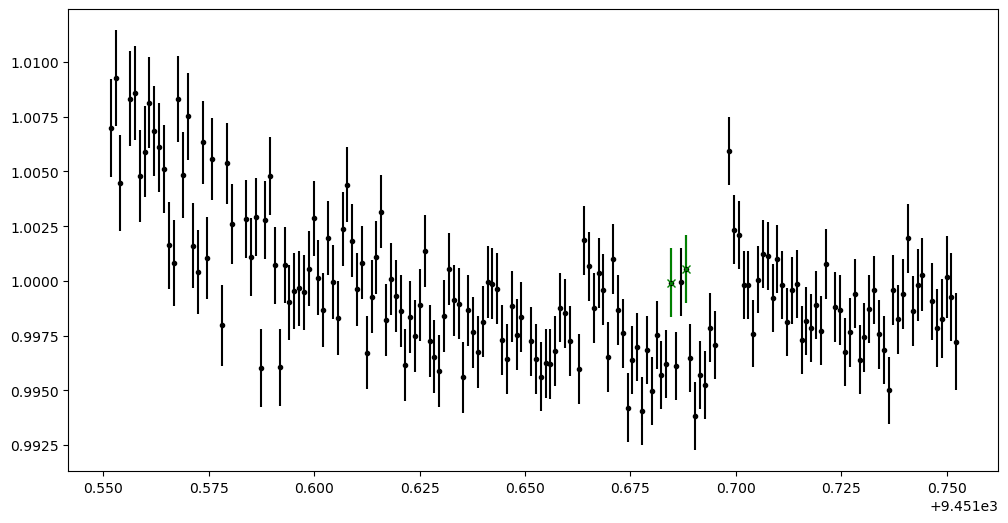

In [87]:
plt.figure(figsize=(12,6))
plt.errorbar(flc.t, flc.f, flc.e, fmt=".", c='k')
# plt.errorbar(flc.t[flc.flare_mask==1.0], flc.f[flc.flare_mask==1.0], flc.e[flc.flare_mask==1.0], fmt=".", c='r')
plt.errorbar(flc.t[flc.flare_i_peak], flc.f[flc.flare_i_peak], flc.e[flc.flare_i_peak], fmt="x", c='green')

# plt.plot(flc.t, teegarden['na4'].value)
# plt.plot(flc.t, teegarden['na5'].value)

In [78]:
flc.get_instrument_response("data/r.txt")

In [86]:
flc.flare_detection(thresh=5, sigma=2.0)

EXPOSURE: 98.49598556756973 seconds
Threshold =  5 , Sigma =  2.0
start run1


/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


SMALL FLARE
1 flare candidates
[10.29336449]
[120]
[110] [164]
Initial guess for parameters:  (1.2, 1.0, 0.001, 0.5, 0.01)
Final guess for parameters:  [9.99790381e-01 3.39871443e-03 1.22846285e-05 4.94266603e-08
 1.25047137e+02]
done run1
run again


/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


SMALL FLARE
1 flare candidates
[11.18392018]
[120]
[110] [164]
Initial guess for parameters:  (1.2, 1.0, 0.001, 0.5, 0.01)
3
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ndarray'>
3
Final guess for parameters:  [1.0003536995135562 8.89295364361034e-14 2.3023362387180817
 7.050846106224029e-14 0.5833935800801704]
run again
0 flare candidates
[]
[]
[] []
[110, 113] [11.183920179173123, 10.293364492639014]
flare recovery done


/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 [110, 113],
 [11.183920179173123, 10.293364492639014])

In [39]:
flc.flare_i_peak

[54, 57, 58]

In [88]:
flares_found = True
flare_i_peak = flc.flare_i_peak #[7,92]
flare_i_peak = [120]
tpeaks, fwhms, ampls = [],[],[]
for flare_i in flare_i_peak:
    tpeaks.append(flc.t[flare_i])
    fwhms.append(0.005)
    ampls.append(np.abs(flc.f[flare_i] - 1))
print(tpeaks, fwhms, ampls)

[9451.698415046325] [0.005] [0.005942115121406966]


In [89]:
degree = 1

In [90]:
# create a pymc3 model
with pm.Model() as model:
    
    # ****** flares *******
    mean = pm.Normal("mean", mu=1.0, sd=3.0, testval=1.0)
    
    if flares_found:
        npeaks = np.shape(tpeaks)[0]
    #     logs2 = pm.Normal("logs2", mu=np.log(np.var(flc.f)), sd=2.0)

        tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
                          testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, shape=npeaks)

        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))

        flare_lc = multiflaremodel(tt.as_tensor_variable(flc.t), tpeak, fwhm, ampl) + mean

        pm.Deterministic("flare_lc", flare_lc)
    else:
        flare_lc = np.ones(len(flc.t)) * mean
    # *************
    
    # ****** polynomials *******
    coeff, variable = [],[]
#     all_polys = []
    all_polys = pm.math.zeros_like(tt.as_tensor_variable(flc.t))
    for xname, x in zip(["FWHM", "dX", 'dY', "bkg", "am"],[teegarden['FWHM'].value,
#                                                                             teegarden['FWHMx'].value,
#                                                                             teegarden['FWHMy'].value,
                                                                            teegarden['dX'].value,
                                                                            teegarden['dY'].value,
                                                                            teegarden['sky_bkg'].value,
                                                                            teegarden['airmass'].value]):
        norm_x = (x - np.mean(x))/np.std(x)
#         degree = pm.DiscreteUniform(f"{xname}_degree",lower=0, upper=2, testval=1)
#         print(degree, eval_in_model(degree))
#         tt.printing.Print(f"{xname}_degree")
        for d in range(1, degree + 1):
            coeff.append(pm.Normal(f"{xname}_p{d}", mu=0.0, sd=1.0, testval=0.001))
            variable.append(norm_x**d)
        poly = pm.math.dot(coeff, variable)
        all_polys = all_polys + poly
#         print(eval_in_model(poly))
        pm.Deterministic(f"{xname}_poly_lc", poly + mean)
    
    pm.Deterministic("total_lc", flare_lc + all_polys)
    
#     nsigma = pm.TruncatedNormal("nsigma", mu=1.0, lower=1.0, sd=0.01, upper=2.0)
    
    pm.Normal("obs", mu=flare_lc + all_polys, sd=flc.e, observed=flc.f) #tt.exp(2*logs2)

In [91]:
with model:
    map_soln = pmx.optimize()

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

optimizing logp for variables: [am_p1, bkg_p1, dY_p1, dX_p1, FWHM_p1, logAmpl, logFwhm, tpeak, mean]


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

message: Desired error not necessarily achieved due to precision loss.
logp: -771.6538978202985 -> 790.4387981357492


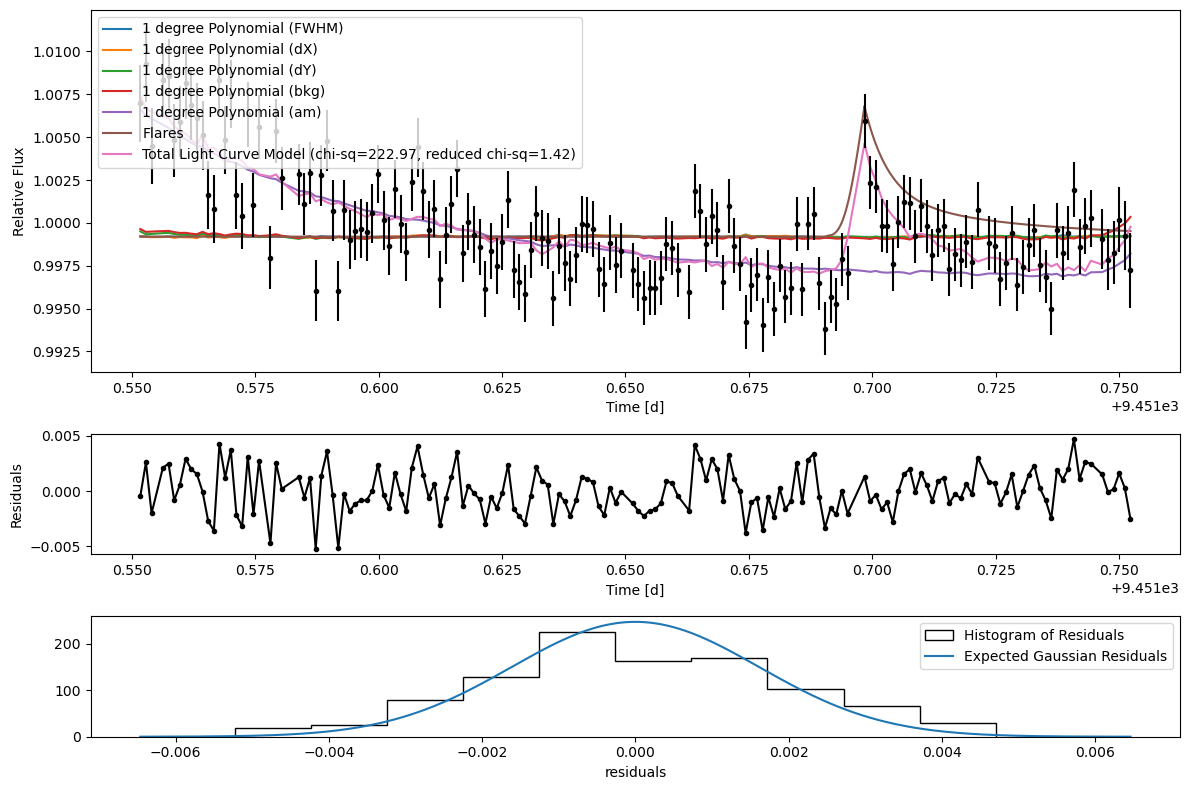

In [92]:
plot_flare_fit(flc, map_soln, degree, npeaks)

In [93]:
with model:
    trace = pm.sample(start=map_soln, draws=1000, tune=1000, chains=4, cores=4)

/var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/ipykernel_76449/989694658.py:2: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(start=map_soln, draws=1000, tune=1000, chains=4, cores=4)
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/s

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(fwhm, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(fwhm, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(fwhm, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(fwhm, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(fwhm, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(fwhm, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [am_p1, bkg_p1, dY_p1, dX_p1, FWHM_p1, logAmpl, logFwhm, tpeak, mean]
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionam

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_vali

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaco

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

In [94]:
import arviz as az
with model:
    summary = az.summary(trace)
summary

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,0.999,0.000,0.999,1.000,0.000,0.000,2723.0,1915.0,1.0
tpeak[0],9451.698,0.001,9451.697,9451.700,0.000,0.000,1264.0,983.0,1.0
logFwhm[0],-4.961,0.345,-5.636,-4.303,0.011,0.008,1151.0,1007.0,1.0
logAmpl[0],-4.851,0.212,-5.246,-4.454,0.006,0.004,1457.0,1471.0,1.0
FWHM_p1,0.000,0.000,-0.000,0.000,0.000,0.000,3843.0,2540.0,1.0
...,...,...,...,...,...,...,...,...,...
total_lc[161],0.998,0.000,0.997,0.999,0.000,0.000,3793.0,2474.0,1.0
total_lc[162],0.998,0.001,0.997,0.999,0.000,0.000,3525.0,2579.0,1.0
total_lc[163],0.999,0.001,0.997,1.000,0.000,0.000,3655.0,2576.0,1.0
total_lc[164],0.999,0.001,0.997,1.001,0.000,0.000,3894.0,2544.0,1.0


In [95]:
params = {}
for k in trace[0].keys():
    params[k] = np.mean(trace[k], axis=0)
params

{'mean': 0.9992180569700179,
 'tpeak': array([9451.69842444]),
 'logFwhm': array([-4.96081334]),
 'logAmpl': array([-4.85124513]),
 'FWHM_p1': 2.3174522209787134e-05,
 'dX_p1': -3.6521752362503344e-05,
 'dY_p1': -7.187200016329889e-05,
 'bkg_p1': 0.0001298430638362159,
 'am_p1': 0.002389794681420007,
 'fwhm': array([0.0074456]),
 'ampl': array([0.00800111]),
 'flare_lc': array([0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921

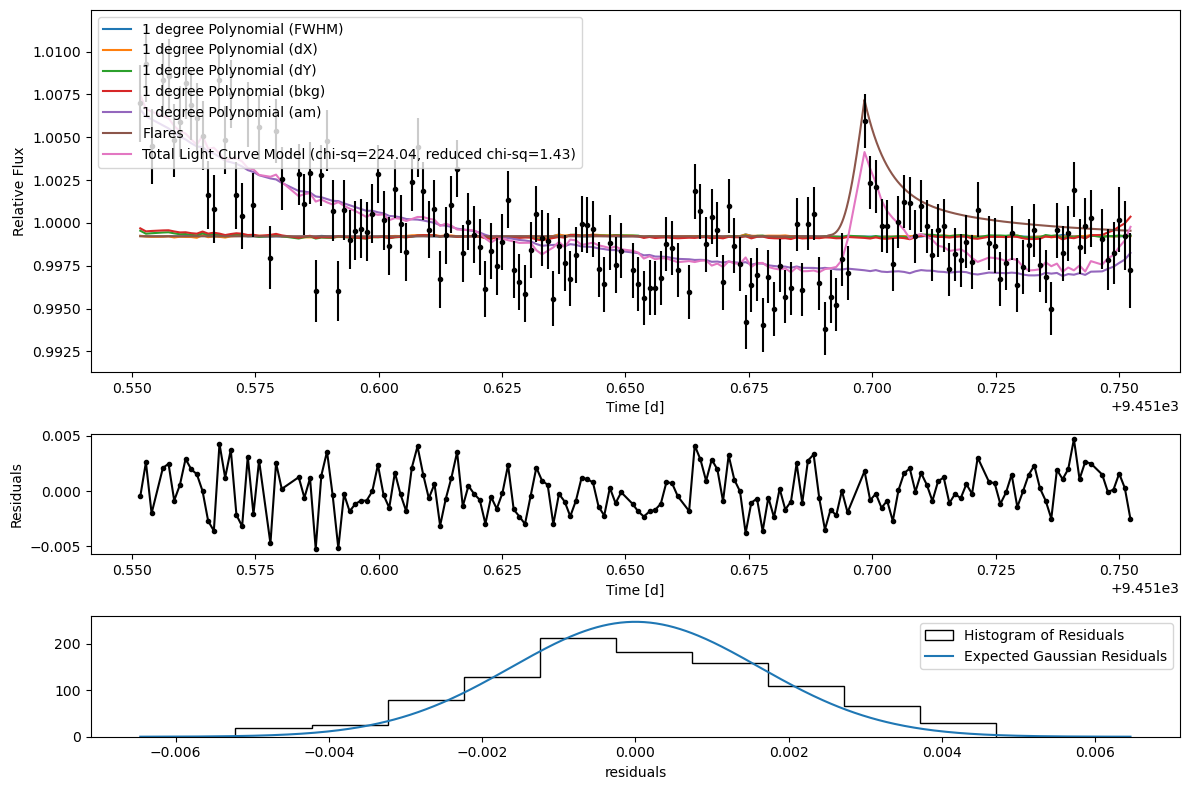

In [96]:
plot_flare_fit(flc, params, degree, npeaks, svname=f'data/teegarden_speculoos/sampling_results/LC_{i}.png')

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'AttributeError'> 'NoneType' object has no attribute 'clients' local_useless_subtensor
ERROR (theano.graph.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.graph.opt): node: Subtensor{int64:int64:int8}(ampl, Constant{0}, Constant{1}, Constant{1})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/opt.py", line 2060, in process_node
    fgraph.replace_all_validate_remove(repl_pairs, reason=lopt, remove=remove)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 612, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/theano/graph/toolbox.py", line 543, in replace_all_va

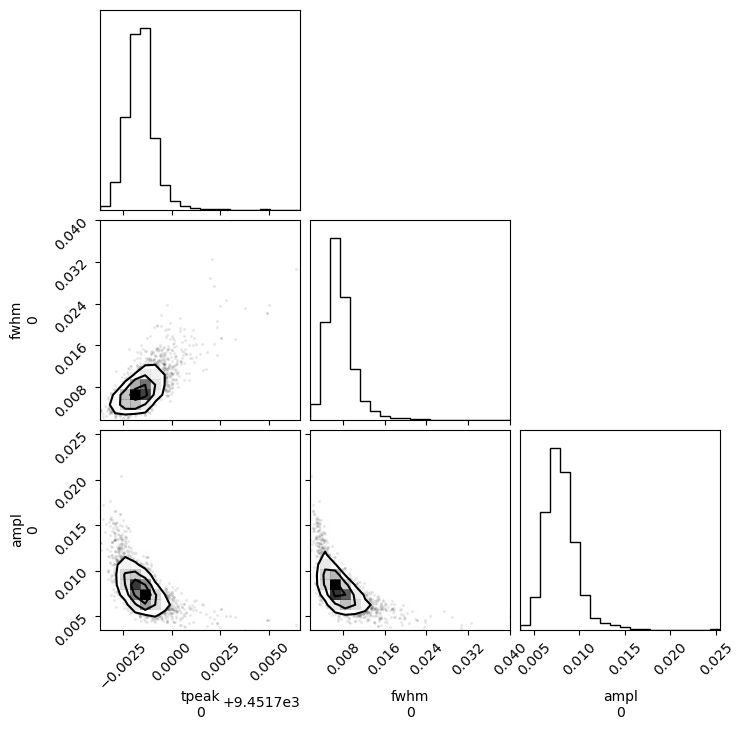

In [97]:
with model:
    corner.corner(trace, var_names=['tpeak', 'fwhm', 'ampl'])
#             var_names=[f'{s.name}_A',f'{s.name}_spot_latitude',
#                                  f'{s.name}_spot_longitude',
#                                  f'{s.name}_spot_contrast',
#                                  f'{s.name}_spot_radius'],)
#                                  f'nsigma',],
#             truths=[1,0,0,0.6, 30,1])
    plt.savefig(f'data/teegarden_speculoos/sampling_results/LC_{i}_corner.png')

In [98]:
flare_df = pd.DataFrame(params['flare_lc']-params['mean'], columns=['flare_model'], index=flc.t)
flare_df.to_csv(f"data/teegarden_speculoos/sampling_results/LC_{i}_flaremodel.csv")

In [99]:
params

{'mean': 0.9992180569700179,
 'tpeak': array([9451.69842444]),
 'logFwhm': array([-4.96081334]),
 'logAmpl': array([-4.85124513]),
 'FWHM_p1': 2.3174522209787134e-05,
 'dX_p1': -3.6521752362503344e-05,
 'dY_p1': -7.187200016329889e-05,
 'bkg_p1': 0.0001298430638362159,
 'am_p1': 0.002389794681420007,
 'fwhm': array([0.0074456]),
 'ampl': array([0.00800111]),
 'flare_lc': array([0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921806, 0.99921806, 0.99921806, 0.99921806, 0.99921806,
        0.99921

In [100]:
def integrate_flare(t, f):
    return integrate.simps(f, t * 24 * 3600)

def flare_energy(t, f, bol_luminosity):
    energy = bol_luminosity * integrate_flare(t, f)  # W s = J
    energy_ergs = energy / 0.0000001
    return energy_ergs

def calculate_bol_luminosity(lam, response, teff, rad):
    teff_flare = 9000  # K
    # teff = 2700 # K

    r_star = rad * 695700 * 1000  # m

    planck_star = [pyasl.planck(teff, x) for x in lam]  # W/(m^2 m)
    planck_flare = [pyasl.planck(teff_flare, x) for x in lam]  # W/(m^2 m)
    int_star = integrate.simps(response * planck_star, lam)
    int_flare = integrate.simps(response * planck_flare, lam)

    A_flare = const.pi * (r_star ** 2) * int_star / int_flare  # m^2
    bol_luminosity = const.Stefan_Boltzmann * (teff_flare ** 4) * A_flare  # W

    return bol_luminosity

def abiogenesis_zone(E_u, R, T):
    flare_freq = [25.5 * ((10 ** 34) / (10 ** E)) * (R ** 2) * (T ** 4) for E in E_u]
    return flare_freq

def energy_uband(int_flare, teff_flare, bolE):
    # teff_flare = 9000  # K
    # planck_flare = [pyasl.planck(teff_flare, x) for x in lam]  # W/(m^2 m)
    # int_flare = integrate.simps(response * planck_flare, lam)
    A_flare = (10 ** bolE) / (const.Stefan_Boltzmann * (teff_flare ** 4))
    E_u = A_flare * int_flare
    print(int_flare)
    return np.log10(E_u)
                    
def cumulative_flare_rate(flare_logEs, logEs, time):
    # get cumulative flare rate for energy bands
    sorted_flare_logEs = sorted(flare_logEs)
    # get cumulative frequency of the flare energies
    res = stats.cumfreq(sorted_flare_logEs, numbins=len(logEs), defaultreallimits=(min(logEs), max(logEs)),
                        weights=None)
    freq = (max(res.cumcount) - res.cumcount) / time
    return freq


def ffd(energies, rad, teff, total_t, int_flare, teff_flare, numflares=2, svname=None):
    thresh_e = []
    thresh_inds = []
    plt.figure()
#     for t in range(len(uniquetargs)):
#         inds = np.where(np.array(targets) == uniquetargs[t])[0]
        #     print(t, inds)
#         energies = np.array(energy)[inds]
        #     print(energies)
#         energies = [x for x in energies if ~np.isnan(x)]
        
    if len(energies) >= numflares:
        thresh_e.append(energies)
#         thresh_inds.append(inds)

        logEs = np.arange(min(energies) - 0.1, max(energies) + 0.1, 0.1)

        logE_us = []
        for E in logEs:
            # IS THIS THE SAME FOR THE r' to U band???
            
            logE_u = 0.12666 * E  # energy_uband(int_flare,teff_flare, E)
            logE_us.append(logE_u)

        # logE_us = np.arange(energy_uband(response_u, lam_u, min(energies) - 0.1), energy_uband(response_u, lam_u, max(energies) + 0.1), 0.1)
        flarerate = cumulative_flare_rate(energies, logEs, total_t)
        # get the abiogenesis zone for plotting
        ab_flarerate = abiogenesis_zone(logE_us, rad, teff / 5778.)

        x = logEs[flarerate != 0.0]
        y = flarerate[flarerate != 0.0]
        points = plt.semilogy(x, y, marker=".", linestyle="None")
        abzone = plt.semilogy(logEs, ab_flarerate, color="green")
        col = points[0].get_color()
        m, b = np.polyfit(x, np.log10(y), 1)
        x_line = np.linspace(28, 36, 1000)
        y_line = m * x_line + b
        plt.semilogy(x_line, [np.power(10, yi) for yi in y_line], color=col, alpha=0.3)
        print("alpha: " + str(m), "beta: " + str(b))

    plt.xlim(28, 36)
    plt.ylim(0.001, 20)
    plt.ylabel("Flare Rate > logE (d^-1)")
    plt.xlabel("logE")
    if svname is None:
        plt.show()
    else:
        plt.savefig(svname)

    plt.close()

    return thresh_e, thresh_inds


This only has to be run once (with the assumption of a 9000K constant BB):

In [101]:
flare_energies = []

In [102]:
teff_flare = 9000
planck_flare = [pyasl.planck(teff_flare, x) for x in flc.lam]
int_flare = integrate.simps(flc.instrument_response * planck_flare, flc.lam)

This only needs to be run once per target:

In [103]:
r_star = flc.r * 695700 * 1000  # m

planck_star = [pyasl.planck(flc.teff, x) for x in flc.lam]  # W/(m^2 m)
int_star = integrate.simps(flc.instrument_response * planck_star, flc.lam)

A_flare = const.pi * (r_star ** 2) * int_star / int_flare  # m^2
bol_luminosity = const.Stefan_Boltzmann * (teff_flare ** 4) * A_flare  # W

In [643]:
# calculate_bol_luminosity(flc.lam, flc.instrument_response, flc.teff, flc.r)

In [646]:
bol_luminosity

1.891639314796896e+24

In [25]:
flare_energy_single = flare_energy(flc.t, map_soln['flare_lc'], bol_luminosity)
flare_energy_single

NameError: name 'flare_energy' is not defined

In [650]:
flare_energies.append(flare_energy_single)

In [678]:
flare_energies

[2.2667787103831374e+35]

In [681]:
total_t = max(flc.t) - min(flc.t)
total_t

0.13867999985814095

In [687]:
ffd(flare_energies, flc.r, flc.teff, total_t, int_flare, teff_flare=9000, numflares=0, svname=None)

ValueError: min() arg is an empty sequence

<Figure size 640x480 with 0 Axes>

In [87]:
flares_start, flares_stop = check_flares_bw(flc.flare_mask, flc.bw_mask, flc.flare_i_peak)

[110, 113]
[108] [155]


In [10]:
flc.flare_mask

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
flc.flare_i_peak

[7, 83, 86]

[110, 113]
[110, 113]
[108] [155]
108 155 110
120 110


/Users/catrionamurray/PycharmProjects/flare_methods/flare_class.py:572: UserWarning: The peak determined by the flare detection code is likely not the real peak. Fixing this now...
  warnings.warn("The peak determined by the flare detection code is likely not the real peak. Fixing this now...")


155 108 12 35
Small Flare!
Fitting the lightcurve with a spline


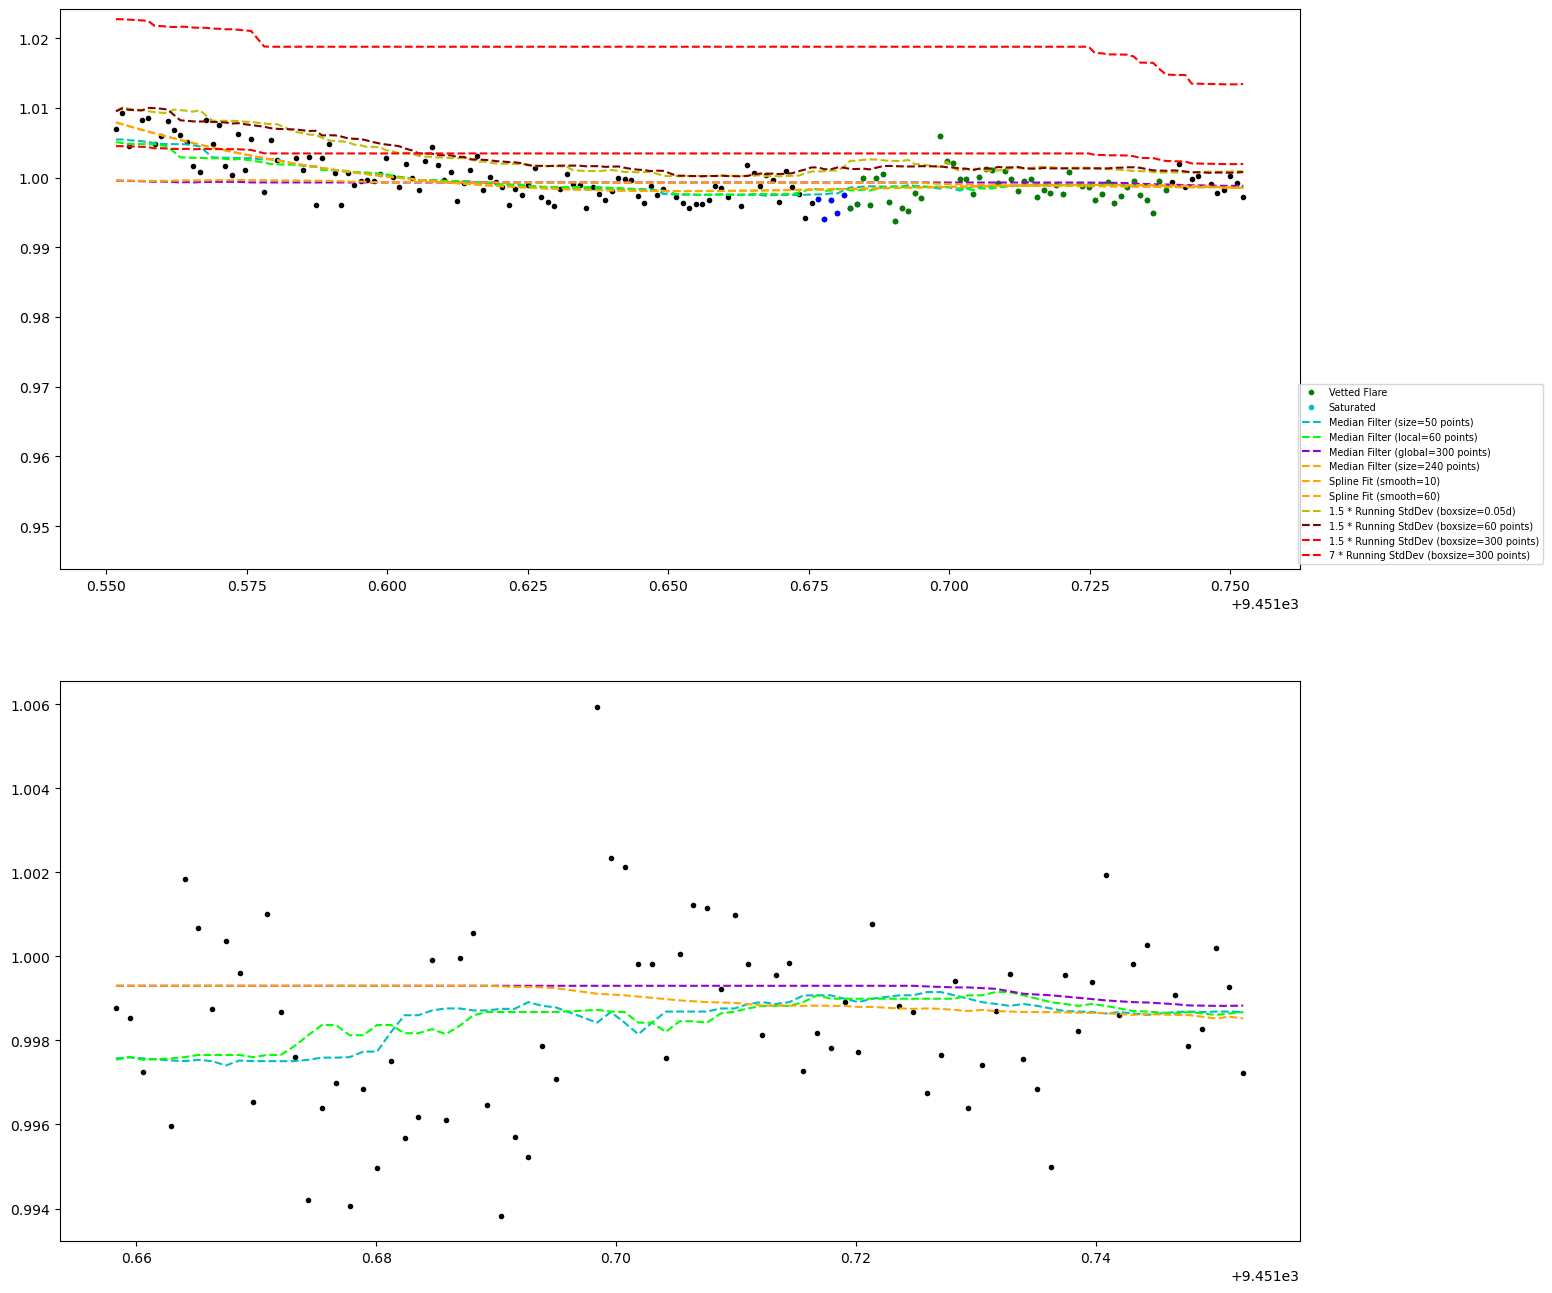

Number of points in LC:  166


SNR:  3.1250146199686073


/Users/catrionamurray/opt/anaconda3/envs/flares_pymc3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


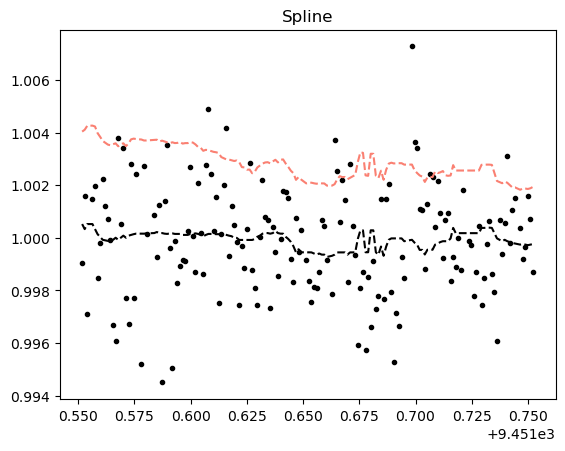

[PEAK FLARE T, FWHM, AMPLITUDE]
Initial guess: (9451.698415046325, 0.018625000026077032, 0.007276173944870568)
Fitted result: [9.45169791e+03 1.67708932e-03 7.27617395e-03]


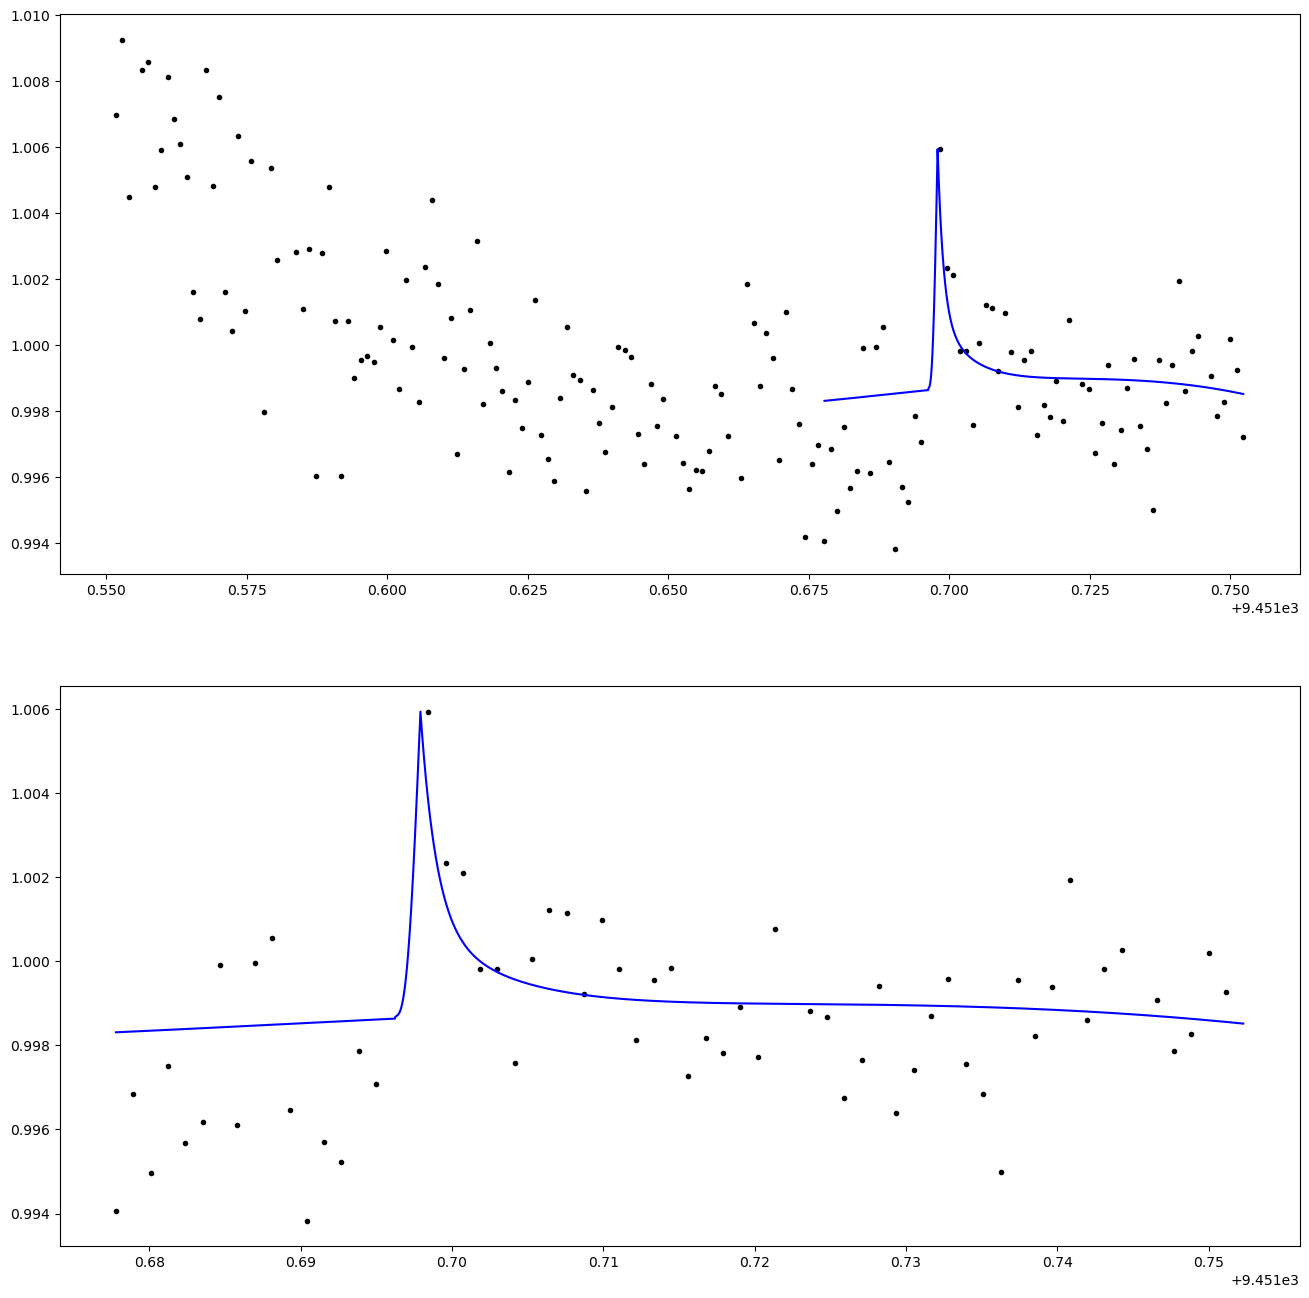

KeyboardInterrupt: 

In [88]:
# localsize=100, globalsize=320, npoints=2, nsigma=2.5, smooth=20, fittype="medfilt",
flc.fit_flares(localsize=60, nsigma=1.5, smooth=10)

In [89]:
flc.flare_i_peak

[120, 113]

In [49]:
from utils import *
from flare_model import fit_davenport_model
from aflare import aflare1

In [50]:
find_nearest(flc.t, flc.flare_tend)

ValueError: operands could not be broadcast together with shapes (127,) (0,) 

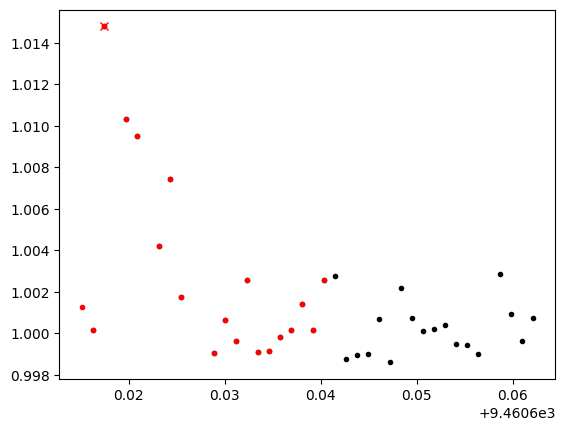

9460.616295046406 9460.644945046166
[PEAK FLARE T, FWHM, AMPLITUDE]
Initial guess: (9460.617435046239, 0.0022914999863132834, 0.014804546693916842)
Fitted result: [9.46061794e+03 1.56780923e-03 1.48056493e-02]
[2.94448746e-03 1.48045467e-02 5.43822638e-03 3.87631831e-03
 2.42276282e-03 2.02830904e-03 1.72868609e-03 1.11845333e-03
 9.71215609e-04 8.43965039e-04 7.34551485e-04 6.38665808e-04
 5.56026820e-04 4.83517274e-04 4.20985580e-04 3.66100876e-04
 3.18373833e-04 2.77206259e-04 2.41069342e-04 2.09898272e-04
 1.82535976e-04 1.58740664e-04 1.38215081e-04 1.20343524e-04
 1.04655618e-04 9.10127795e-05 7.92445990e-05 6.89143255e-05
 6.00035344e-05 5.21815135e-05 4.53791635e-05 3.95115266e-05
 2.99178891e-05 2.60178130e-05 2.26261482e-05 1.97005319e-05]


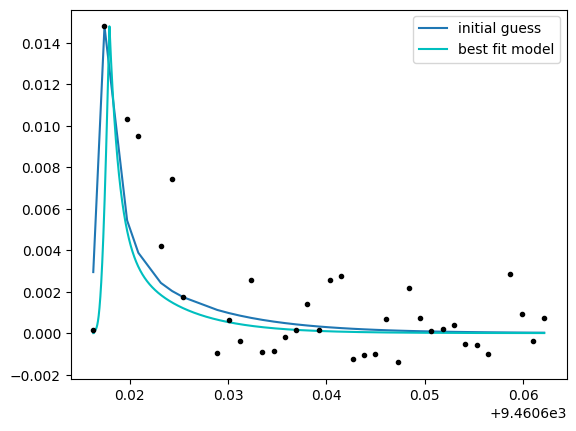

(array([9.46061794e+03, 1.56780923e-03, 1.48056493e-02]),
 array([9460.61629505, 9460.61630505, 9460.61631506, ..., 9460.66210504,
        9460.66211504, 9460.66212505]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.78195113e-06, 1.77878923e-06, 1.77563295e-06]))

In [17]:
fit_davenport_model_2(flc.t, flc.f, istart=0, istop=19,ipeak=2, buffer=0.5 / 24., small_flare=False, debug=True)

In [16]:
def fit_davenport_model_2(time, flux, istart, istop, ipeak, buffer, small_flare, debug):
    # ADAPTED FROM FLATWRN
    # We also save the stdev for calculating start/end times
    # stdev = np.std((f - model)[regressor.inlier_mask_])

    # midflare = (time[istart] + time[istop]) / 2.
    try:
        if small_flare:
            window_mask = (time > time[max(istart - 5, 0)]) \
                          * (time < time[min(istop, len(time) - 1)] + buffer)
        else:
            window_mask = (time > time[max(istart - 10, 0)]) \
                          * (time < time[min(istop, len(time) - 1)] + buffer)
        t = time[window_mask]
        f = flux[window_mask]
        # print(max(istart - 5,0),time[max(istart - 5,0)],t[0],time[ipeak],t[ipeak - max(istart - 5,0)-1])
        # ipeak = ipeak - max(istart - 5,0)
        if debug:
            plt.plot(t, f, 'k.')
            plt.plot(time[istart:istop], flux[istart:istop], 'r.')
            plt.plot(time[ipeak], flux[ipeak], 'rx')
            plt.show(block=True)
            plt.close()

        f = f - 1  # np.nanmedian(f[0:ipeak - max(istart - 5,0)-2])
    except Exception as e:
        print(e)

    try:
        global fwhm  # I know, there is a special place in hell for this...
        if fwhm == 0:  # not defined as command-line argument
            fwhm = 1. / 24  # Selected by educated random guessing
    except NameError:
        fwhm = 1. / 24  # If calling just this function this might be handy

    # imax = np.nanargmax(f)
    # print(ipeak,np.nanargmax(flux),np.nanargmax(flux[0:ipeak+2]))
    # imax = ipeak - max(istart - 5,0)-1
    tpeak = time[ipeak]  # t[imax]
    ampl = flux[ipeak] - 1  # f[imax]#np.nanmax(f)
    if not np.isfinite(ampl):
        ampl = flux[np.nanargmax(flux)]
    fwhm = 0.05 * (t[-1] - t[0])

    pguess = (tpeak, fwhm, ampl)

    try:
        if small_flare:
            minflaret = t[0]  # t[imax-2]
            maxflaret = time[min(ipeak + 3, len(time) - 1)]  # t[imax+2]
        else:
            minflaret = t[0]
            maxflaret = time[min(ipeak + 20, len(time) - 1)]  # t[imax+20]
        print(minflaret, maxflaret)
        popt1, pcov = curve_fit(aflare1, t, f, p0=pguess,
                                bounds=([minflaret, 0, ampl], [maxflaret, 10 * fwhm, 5 * ampl]))
    except ValueError:
        # tried to fit bad data, so just fill in with NaN's
        # shouldn't happen often
        popt1 = np.array([np.nan, np.nan, np.nan])
    except RuntimeError:
        # could not converge on a fit with aflare
        # fill with bad flag values
        popt1 = np.array([-99., -99., -99.])

    print("[PEAK FLARE T, FWHM, AMPLITUDE]")
    print("Initial guess:", pguess)
    print("Fitted result:", popt1)

    flare_t = np.linspace(np.min(t), np.max(t), int((t[-1] - t[0]) * 100000))
    flare_f = aflare1(flare_t, popt1[0], popt1[1], popt1[2])
    if debug:
        initial_guess = aflare1(t, pguess[0], pguess[1], pguess[2])
        print(initial_guess)
        plt.plot(t, initial_guess, label="initial guess")
        plt.plot(flare_t, flare_f, 'c', label='best fit model')
        plt.plot(t, f, 'k.')
        plt.legend()
        plt.show()
        plt.close()

    return popt1, flare_t, flare_f

In [86]:
flc.flare_i_peak

[7, 86]

In [87]:
np.argmax(flc.f)

92

In [88]:
# flare_i_peak = flc.flare_i_peak
flare_i_peak = [7,92]

[9461.550875046523, 9461.660935046384] [0.005, 0.005] [0.001860243807527695, 0.09016747906108602]
[[Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0], [Subtensor{int64}.0, Subtensor{int64}.0, Subtensor{int64}.0]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


optimizing logp for variables: [tpeak, fwhm, amplitude]


message: Optimization terminated successfully.
logp: -9997.998833013744 -> -9997.998833013744



{'amplitude': array([0.00186024, 0.09016748]), 'fwhm': array([0.005, 0.005]), 'tpeak': array([9461.55087505, 9461.66093505])}


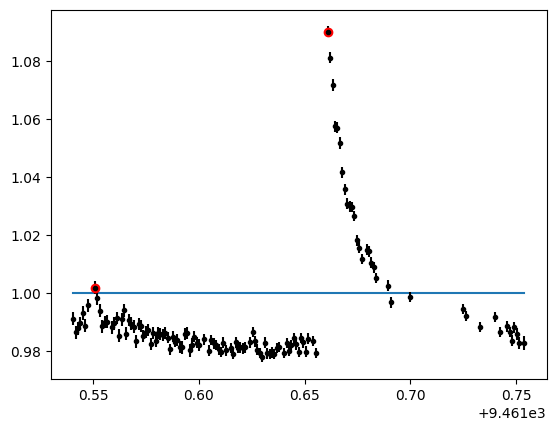

In [103]:
tpeak, fwhm, amp = [],[],[]
for flare_i in flare_i_peak:
    tpeak.append(flc.t[flare_i])
    fwhm.append(0.005)
    amp.append(np.abs(flc.f[flare_i] - 1))
print(tpeak, fwhm, amp)
    
with pm.Model() as mod:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    flare_amplitude = pm.Normal("amplitude",mu=amp, sigma=0.1, shape=len(flare_i_peak))
    flare_fwhm = pm.Normal("fwhm", mu=fwhm, sigma=0.05, shape=len(flare_i_peak))
    flare_peak = pm.Normal('tpeak', mu=tpeak, sigma=0.05, shape=len(flare_i_peak))

    p = []
    for i in range(len(flare_i_peak)):
        p.append([flare_peak[i],flare_fwhm[i],flare_amplitude[i]])
    print(p)
    flare_model = aflare_pymc(flc.t, p)
    print(flare_model)

        # This is how we tell `pymc3` about our observations;
        # we are assuming they are ampally distributed about
        # the true model. This line effectively defines our
        # likelihood function.
    pm.Normal("obs", flare_model, sd=flc.e, observed=flc.f - 0.98)#np.nanmedian(flc.f[flare_i-5:flare_i-1]))
        
    map_soln = pmx.optimize()
        
    print(map_soln)
    model = aflare_pymc(flc.t, [[tp, f, a] for tp, f, a in zip(map_soln['tpeak'],map_soln['fwhm'],map_soln['amplitude'])])
    plt.figure()
    plt.plot(flc.t, model+ 1)#np.nanmedian(flc.f[flare_i-5:flare_i-1]))
    plt.errorbar(flc.t, flc.f, flc.e, fmt='.', c='k')
    plt.plot(flc.t[flare_i_peak], flc.f[flare_i_peak], 'ro')
    

In [78]:
import pymc3 as pm
import pymc3_ext as pmx
from pymc3_ext import eval_in_model

In [2]:
from xoflares import *

In [ ]:
#     multiflaremodel,
    # multiflare,
#     multiflaremodelnp,
#     get_light_curvenp,
#     get_light_curve,
#     eval_get_light_curve,
#     multiflareintegral,
#     multiflareintegralnp,
#     eval_multiflareintegral,
#     multiflare

In [66]:
def aflare1_pymc(t, tpeak, fwhm, ampl):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723

    Use this function for fitting classical flares with most curve_fit
    tools.

    Note: this model assumes the flux before the flare is zero centered

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare

    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    
    
    fl = np.piecewise(t, [(t <= tpeak) * (t - tpeak) / fwhm > -1.,
                          (t > tpeak)],
                      [lambda x: (_fr[0] +  # 0th order
                                  _fr[1] * ((x - tpeak) / fwhm) +  # 1st order
                                  _fr[2] * ((x - tpeak) / fwhm) ** 2. +  # 2nd order
                                  _fr[3] * ((x - tpeak) / fwhm) ** 3. +  # 3rd order
                                  _fr[4] * ((x - tpeak) / fwhm) ** 4.),  # 4th order
                       lambda x: (_fd[0] * np.exp(((x - tpeak) / fwhm) * _fd[1]) +
                                  _fd[2] * np.exp(((x - tpeak) / fwhm) * _fd[3]))]
                      )
    flare = fl * np.abs(ampl) / max(fl)
    return flare

In [92]:
def aflare_pymc(t, p):
    """
    This is the Analytic Flare Model from the flare-morphology paper.
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723

    Note: this model assumes the flux before the flare is zero centered

    Note: many sub-flares can be modeled by this method by changing the
    number of parameters in "p". As a result, this routine may not work
    for fitting with methods like scipy.optimize.curve_fit, which require
    a fixed number of free parameters. Instead, for fitting a single peak
    use the aflare1 method.

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    p : 1-d array
        p == [tpeak, fwhm (units of time), amplitude (units of flux)] x N

    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    """
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    Nflare = int( np.floor( (len(p)/3.0) ) )

    flare = np.zeros_like(t)
    # compute the flare model for each flare
    for i in range(Nflare):
        outm = np.piecewise(t, [(t<= p[0+i*3]) * (t-p[0+i*3])/p[1+i*3] > -1.,
                                (t > p[0+i*3])],
                            [lambda x: (_fr[0]+                             # 0th order
                                        _fr[1]*((x-p[0+i*3])/p[1+i*3])+     # 1st order
                                        _fr[2]*((x-p[0+i*3])/p[1+i*3])**2.+  # 2nd order
                                        _fr[3]*((x-p[0+i*3])/p[1+i*3])**3.+  # 3rd order
                                        _fr[4]*((x-p[0+i*3])/p[1+i*3])**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-p[0+i*3])/p[1+i*3])*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-p[0+i*3])/p[1+i*3])*_fd[3] ))]
                            ) * p[2+i*3] # amplitude
        flare = flare + outm
        
    return flare

In [24]:
def mendoza22_flare_eqn(t, ampl):
    '''
    The equation that defines the shape for the Continuous Flare Model
    '''
    #Values were fit & calculated using MCMC 256 walkers and 30000 steps

    A,B,C,D1,D2,f1 = [0.9687734504375167, -0.251299705922117, 0.22675974948468916,
                      0.15551880775110513, 1.2150539528490194, 0.12695865022878844]

    # We include the corresponding errors for each parameter from the MCMC analysis

    A_err,B_err,C_err,D1_err,D2_err,f1_err = [0.007941622683556804,0.0004073709715788909,0.0006863488251125649,
                                              0.0013498012884345656,0.00453458098656645,0.001053149344530907 ]

    f2 = 1 - f1

    eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)
                        * special.erfc(((B - t) / C) + (C * D1 / 2))) + ((1 / 2) * np.sqrt(np.pi) * A * C * f2
                        * np.exp(-D2 * t+ ((B / C) + (D2 * C / 2)) ** 2) * special.erfc(((B - t) / C) + (C * D2 / 2)))
    return eqn * ampl

In [31]:
with pm.Model() as mod:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    flare_amplitude = pm.Normal("amplitude",mu=amp, sigma=0.1*amp)
    flare_fwhm = pm.Normal("fwhm", mu=fwhm, sigma=0.01)
    flare_peak = pm.Normal('tpeak', mu=tpeak, sigma=0.01)
    
    flare_model = aflare1_pymc(flc.t, eval_in_model(flare_peak),eval_in_model(flare_fwhm),flare_amplitude)
    print(flare_model)

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flare_model, sd=flc.e, observed=flc.f-1)

Elemwise{true_div,no_inplace}.0


In [32]:
with mod:
    map_soln = pmx.optimize()

optimizing logp for variables: [tpeak, fwhm, amplitude]


message: Optimization terminated successfully.
logp: 540.7855963070282 -> 541.6719137411076


<ErrorbarContainer object of 3 artists>

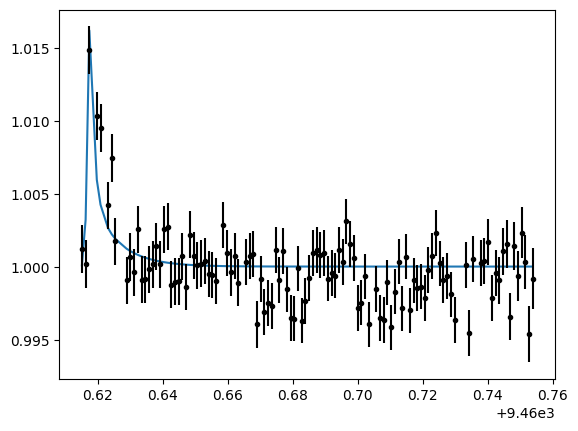

In [37]:
map_soln
model = aflare1_pymc(flc.t, map_soln['tpeak'],map_soln['fwhm'],map_soln['amplitude'])
plt.plot(flc.t, model+1)
plt.errorbar(flc.t, flc.f, flc.e, fmt='.', c='k')

In [ ]:
with mod:
    trace = pm.sample(
        tune=100,
        draws=100,
        start=map_soln,
        chains=2,
        cores=2,
        target_accept=0.9,
    )

In [8]:
aesara_theano_fallback.as

<module 'aesara_theano_fallback.tensor' from '/Users/catrionamurray/opt/anaconda3/envs/flares/lib/python3.9/site-packages/aesara_theano_fallback/tensor.py'>